In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim.lr_scheduler as lr_scheduler

# import sys 
# sys.path.append
# from wave_solvers_v2 import num_step, ml_step, make_matrix, num_stencils
from train_ml import train_ml
from KS_solver import KS_step, ml_step

from jax_models import *

In [2]:
class Model(nn.Module):
    def __init__(self, stencil, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.stencil = stencil
        
        # RNN Layer
        self.lstm = nn.LSTM(stencil, hidden_dim, n_layers, batch_first=True).double()
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim, hidden_dim).double()
        self.fc2 = nn.Linear(hidden_dim, 1).double()
#         self.trf = nn.Linear(stencil, stencil).double()
        cm = Parameter(torch.tensor([[0.8,-0.2,-0.2,-0.2,-0.2],[-0.2,0.8,-0.2,-0.2,-0.2],[-0.2,-0.2,0.8,-0.2,-0.2],[-0.2,-0.2,-0.2,0.8,-0.2],[-0.2,-0.2,-0.2,-0.2,0.8]]).double())#1st order
        #cm = Parameter(torch.tensor([[0.4,-0.4,-0.2,0,0.2],[-0.4,0.7,-0.2,-0.1,0],[-0.2,-0.2,0.8,-0.2,-0.2],[0,-0.1,-0.2,0.7,-0.4],[0.2,0,-0.2,-0.4,0.4]]).double())#2nd order
        #cm = Parameter(torch.tensor([[4/35,-9/35,3/35,1/7,-3/35],[-9/35,22/35,-12/35,-6/35,1/7],[3/35,-12/35,18/35,-12/35,3/35],[1/7,-6/35,-12/35,22/35,-9/35],[-3/35,1/7,3/35,-9/35,4/35]]).double())#3rd order
        cv = Parameter(torch.tensor([0.2,0.2,0.2,0.2,0.2]).double())#1st order
        #cv = Parameter(torch.tensor([0.1,0.15,0.2,0.25,0.3]).double())#2nd order
        #cv = Parameter(torch.tensor([-17/105,59/210,97/210,8/21,4/105]).double())#3rd order
#         self.trf.bias = cv
#         self.trf.weight = cm
        
#         for p in self.trf.parameters():
#             p.requires_grad=False
    
    def forward(self, ui, hidden):
        Nx = ui.size(1)
        Nt = ui.size(0)
        uip = torch.zeros(Nt,Nx,self.stencil).double()

        uip = resh(ui, self.stencil)
        # cm = torch.zeros_like(uip)
        # cm[:,:,:] = Parameter(torch.ones(self.stencil)/self.stencil)
        
        f, hidden = self.lstm(uip, hidden)# Passing in the input and hidden state into the model and obtaining outputs
        f = self.fc1(f)
        u_out = self.fc2(f)

#         f = self.trf(f)
        print('hidden', hidden.shape)
        
        return u_out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim,dtype=torch.double)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_dim,dtype=torch.double)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hc = (hidden,cell)
        return hc

In [3]:
def resh(ui, stencil):
    Nt = ui.size(0)
    Nx = ui.size(1)
    print(Nx, Nt)
    U_proc = torch.zeros(Nt,Nx,stencil).double()
    
    for i,kroll in enumerate(range(-(stencil-1)//2, stencil//2+1)):
        print(i,kroll)
        U_proc[:,:,i] = ui.roll(kroll,1)
    
    return U_proc

def f_rand(L):
    nwaves = 5
    a = np.arange(nwaves)+1
    b = np.random.rand(nwaves)
    d = np.random.rand(nwaves)

    xi = np.linspace(0,L,1000)
    fx = xi*0
    for i in range(nwaves):
        fx = fx + b[i]*np.sin(2*a[i]*np.pi*(xi-d[i])/L)
        
    mina = np.min(fx)
    maxa = np.max(fx)

    def f(x):
        fx = x*0
        for i in range(nwaves):
            fx = fx + b[i]*np.sin(2*a[i]*np.pi*(x-d[i])/L)
            
        fx = (fx - mina) / (maxa - mina)   
        return fx

    return f

def makeICdsc(KS):
    def IC(num_steps):
        x = np.arange(0,KS.l,KS.l/KS.s)
        y_full = np.zeros((num_steps+1, KS.s))
        y_full[0] = f_rand(KS.l)(x)
        for i in range(num_steps):
            y_full[i+1] = KS.step(y_full[i])

        return y_full
    return IC

In [4]:
stencil=3

# Instantiate the model with hyperparameters
model = Model(stencil=stencil, output_size=1, hidden_dim=16, n_layers=3)

# Define hyperparameters
n_epochs = 200
lr = 0.001

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr)
optimizer2 = torch.optim.LBFGS(model.parameters(), lr=lr)
optimizer = optimizer1

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-5, factor=0.5)

errs_NN = torch.zeros(n_epochs)
rel_err = torch.zeros(n_epochs)

randgr = 0
S = 100
L = 22

In [5]:
dt = 0.25
s = 128
l=L
M=16
KS = KuramotoSivashinsky(dt=dt, s=s, l=l, M=M)

In [6]:
batch_size = KS.s
IC_fx = makeICdsc(KS)
mbs = 5

In [9]:
TV = torch.zeros((n_epochs,mbs),dtype=torch.double)
losses=[]
for epoch in range(0, n_epochs):
    optimizer.zero_grad()
    target_seq_a = torch.zeros((S+1,l,mbs),dtype=torch.double)
    output_a = torch.zeros((S+1,l,mbs),dtype=torch.double)
    for j in range(0,mbs):
            
        solt = torch.tensor(IC_fx(S))
        IC = solt[0,:]
        target_seq = solt
        
        hidden1 = model.init_hidden(batch_size)        
        x_t = solt[0,:]
        output = torch.zeros_like(target_seq)
        output[0,:] = x_t
        
        hidden = hidden1
        for i in range(0,S):
            x_t, hidden = model(x_t,hidden)
            output[:,i+1,:] = x_t
        target_seq_a[:,:,:,j] = target_seq
        output_a[:,:,:,j] = output

    loss = criterion(output_a.flatten(), target_seq_a.flatten()) #maybe penalize 1-norm
    
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    scheduler.step(loss)
    if epoch%10 == 0:
        '''
        plt.clf()
        plt.plot(output.flatten().detach())
        plt.plot(target_seq.flatten().detach())
        plt.pause(0.001)
        '''
        
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss))
        print("LR: {:.7f}".format(optimizer.param_groups[0]["lr"]))
#     plt.clf()
#     #plt.plot(torch.cat((rel_errppp,rel_err[rel_err!=0])).detach())
#     plt.semilogy(rel_err[rel_err!=0].detach())
#     plt.pause(0.01)

torch.Size([1, 1, 128])
128 1
0 -1
1 0
2 1


RuntimeError: Expected hidden[0] size (3, 1, 16), got [3, 128, 16]

In [73]:
3//2

1

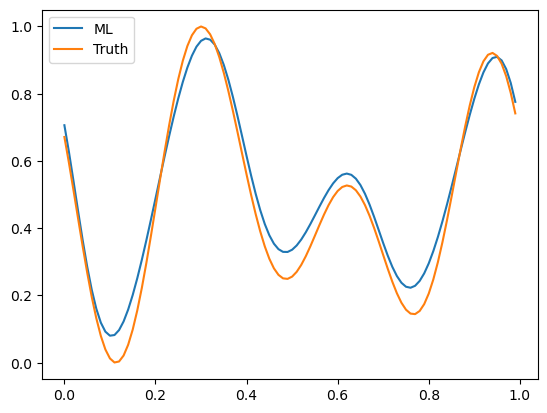

In [9]:
plt.plot(xc, output[0,-1,:].detach().numpy(), label='ML')
plt.plot(xc, target_seq[0,-1,:].detach().numpy(), label='Truth')
plt.legend()

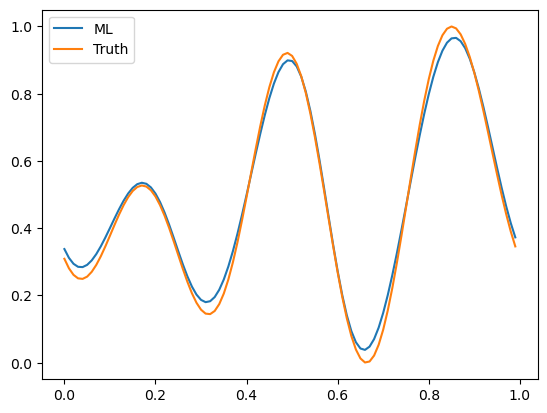

In [10]:
plt.plot(xc, output[0,50,:].detach().numpy(), label='ML')
plt.plot(xc, target_seq[0,50,:].detach().numpy(), label='Truth')
plt.legend()

# Use LSTM in prediction mode

In [8]:
S = 10000
T = dt*(S)
xc = torch.linspace(0,L,int(L/dx)+1,dtype=torch.double)
xc = xc[:-1]
tc = torch.linspace(0,T,int(T/dt)+1,dtype=torch.double)
xg,tg = torch.meshgrid(xc,tc)#make the coarse grid
solt = torch.t(IC_fx((xg-tg)%L)).unsqueeze(0)
IC = solt[0,0,:]
target_seq = solt

In [9]:
hidden1 = model.init_hidden(batch_size)        
x_t = solt[0,0,:]
output = torch.zeros_like(target_seq)
x_t = x_t.unsqueeze(0)
x_t = x_t.unsqueeze(0)
y_t = x_t[:,:,:]
fis = torch.zeros((len(xc), S, stencil),dtype=torch.double)
fs = torch.zeros((len(xc), S, stencil),dtype=torch.double)
output[:,0,:] = x_t
for i in range(0,S):
    x_t, hidden1, f, fi = model(x_t,dt,dx, hidden1)
    fis[:,i,:] = fi.squeeze()
    fs[:,i,:] = f.squeeze()
    output[:,i+1,:] = x_t

output = output.squeeze(0).detach().numpy()
target_seq = target_seq.squeeze(0).detach().numpy()

In [10]:
target_seq.shape

(10001, 100)

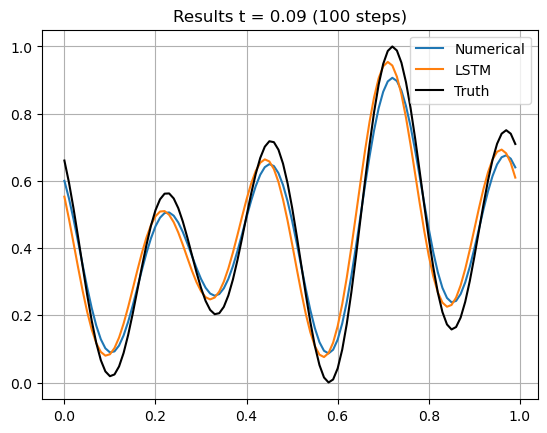

In [11]:
num_steps_test = 100
num_result = num_step(target_seq[0], dt, num_steps_test, stencil=stencil, all_steps=False)
data_result = target_seq[num_steps_test]
x = xc.detach().numpy()

plt.plot(x, num_result, label='Numerical')
plt.plot(x, output[num_steps_test], label='LSTM')
plt.plot(x, data_result, c='black', label='Truth')
plt.title(f'Results t = {round(dt*num_steps_test, 3)} ({num_steps_test} steps)')
plt.legend()
plt.grid()

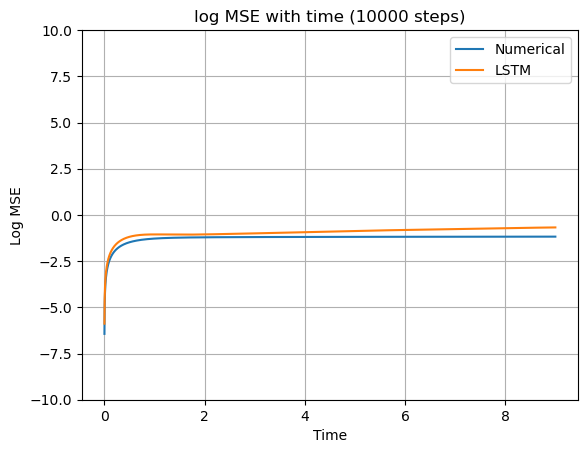

In [12]:
num_steps_test = S # int(5/dt)
num_result = num_step(target_seq[0], dt, num_steps_test, stencil=stencil, all_steps=True)
data_result = target_seq

plt.plot(tc[1:], np.log10(np.mean((num_result[1:,:]-data_result[1:,:])**2, axis=1)), label='Numerical')
plt.plot(tc[1:], np.log10(np.mean((output[1:,:]-data_result[1:,:])**2, axis=1)), label='LSTM')
plt.title(f'log MSE with time ({num_steps_test} steps)')
plt.xlabel("Time")
plt.ylabel("Log MSE")
plt.ylim([-10,10])
plt.legend()
plt.grid()

In [22]:
output.shape

(101, 100)

In [44]:
dist = fsn.sum(axis=2)

(array([9226.,  253.,  121.,  100.,   16.,   84.,    0.,  100.,    0.,
         100.]),
 array([-0.00954142, -0.00156958,  0.00640226,  0.0143741 ,  0.02234595,
         0.03031779,  0.03828963,  0.04626147,  0.05423331,  0.06220515,
         0.07017699]),
 <BarContainer object of 10 artists>)

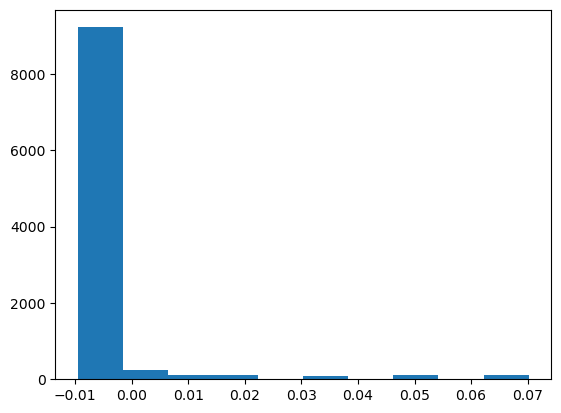

In [45]:
plt.hist(dist.reshape(-1))

In [45]:
fis

tensor([[[ 0.0394, -0.0287],
         [ 0.0197, -0.0122],
         [ 0.0080, -0.0030],
         ...,
         [-0.0074,  0.0074],
         [-0.0074,  0.0074],
         [-0.0074,  0.0074]],

        [[ 0.0393, -0.0286],
         [ 0.0196, -0.0122],
         [ 0.0080, -0.0030],
         ...,
         [-0.0074,  0.0074],
         [-0.0074,  0.0074],
         [-0.0074,  0.0074]],

        [[ 0.0393, -0.0286],
         [ 0.0195, -0.0122],
         [ 0.0079, -0.0030],
         ...,
         [-0.0074,  0.0074],
         [-0.0074,  0.0074],
         [-0.0074,  0.0074]],

        ...,

        [[ 0.0393, -0.0285],
         [ 0.0195, -0.0119],
         [ 0.0078, -0.0025],
         ...,
         [-0.0074,  0.0074],
         [-0.0074,  0.0074],
         [-0.0074,  0.0074]],

        [[ 0.0393, -0.0286],
         [ 0.0196, -0.0121],
         [ 0.0080, -0.0027],
         ...,
         [-0.0074,  0.0074],
         [-0.0074,  0.0074],
         [-0.0074,  0.0074]],

        [[ 0.0394, -0.0286],
       